<a href="https://colab.research.google.com/github/amazon4b/Learning-Machine/blob/learner1/%EA%B2%BD%EA%B8%B0%EB%B6%84%EC%84%9D%2Ck_means(k%3D4)%2Cmeanshift%2C_minmax%EC%8A%A4%EC%BC%80%EC%9D%BC%EB%A7%81_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import warnings

# 경고 메시지를 출력하지 않도록 설정
warnings.filterwarnings("ignore")

# 경고 메시지를 발생시키는 함수
def example_function():
    warnings.warn("이 함수는 예제일 뿐입니다.", UserWarning)

# 함수 호출
example_function()

In [67]:
# 기본패키지 설치
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans # 케이민즈 알고리즘
from sklearn.preprocessing import StandardScaler# 스텐다드 스케일러
# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc

In [68]:
# 데이터프레임 불러오기
economics = pd.read_csv('./datasets/resampled_data_final.csv',encoding="euc-kr")
economics['DATE'] = pd.to_datetime(economics['DATE'])
economics['DATE'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 289 entries, 0 to 288
Series name: DATE
Non-Null Count  Dtype         
--------------  -----         
287 non-null    datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.4 KB


In [69]:
# economics.drop(['장단기10년물국채/3개월금리차','신규실업수당청구','금융상태지수레버리지','제조업신규주문'],axis=1,inplace=True)

In [70]:
economics[economics.isna().any(axis=1)] # 결측치 확인

,DATE,장단기10년물국채/3개월금리차,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,금융상태지수레버리지,소비자감성지수,기준금리,제조업신규주문,M2통화량,신규실업수당청구,경기동행종합,산업생산지수,소매판매
287,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
288,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
economics = economics.iloc[:287 , ] # 결측치 제거
economics[economics.isna().any(axis=1)] # 결측치 확인

,DATE,장단기10년물국채/3개월금리차,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,금융상태지수레버리지,소비자감성지수,기준금리,제조업신규주문,M2통화량,신규실업수당청구,경기동행종합,산업생산지수,소매판매


In [72]:
# 2000년~2019년만 군집화하기 위함 , 코로나 데이터가 이상치로 잡히기 때문에 군집이 제대로 형성되지 않음
economics = economics.loc[economics['DATE'].dt.year <=2019 ]

In [73]:
# 주택가격지수. 제조업신규주문 , 경기동행종합지수는 차분하고 (변동치로 변경한다는 뜻)
# 제조업 신규주문은 앞으로 어떻게 처리할지 일단 보류
#M2와 소매판매는 변화율로 바꾸는 전처리 시행
economics.주택가격지수 = economics.주택가격지수.diff().fillna(method= 'bfill')
economics.경기동행종합 = economics.경기동행종합.diff().fillna(method= 'bfill')
economics['M2차분'] = economics.M2통화량.diff().fillna(method= 'bfill')
economics['M2변화율'] = economics.M2차분/ (economics.M2통화량.shift(1)) * 100
#economics['M2변화율'] .fillna(method = 'ffill')
economics['소매판매차분'] = economics.소매판매.diff().fillna(method='bfill')
economics['소매판매변화율'] = economics.소매판매차분/ (economics.소매판매.shift(1)) * 100


# 차분, 변화율 확인
economics[['M2통화량','M2차분','M2변화율','소매판매','소매판매차분','소매판매변화율']].head(10)
# 결측치를 다음날 데이터로 채워주기
economics['M2변화율'] = economics['M2변화율'].fillna(method = 'bfill')
economics['소매판매변화율'] = economics['소매판매변화율'].fillna(method = 'bfill')
# M2, 소매판매 원데이터를 지웠습니다.
economics.drop(['M2통화량','M2차분','소매판매','소매판매차분'],axis = 1,inplace = True)

In [74]:
# 다시 날짜를 인덱스로 설정해주기
economics = economics.set_index('DATE')

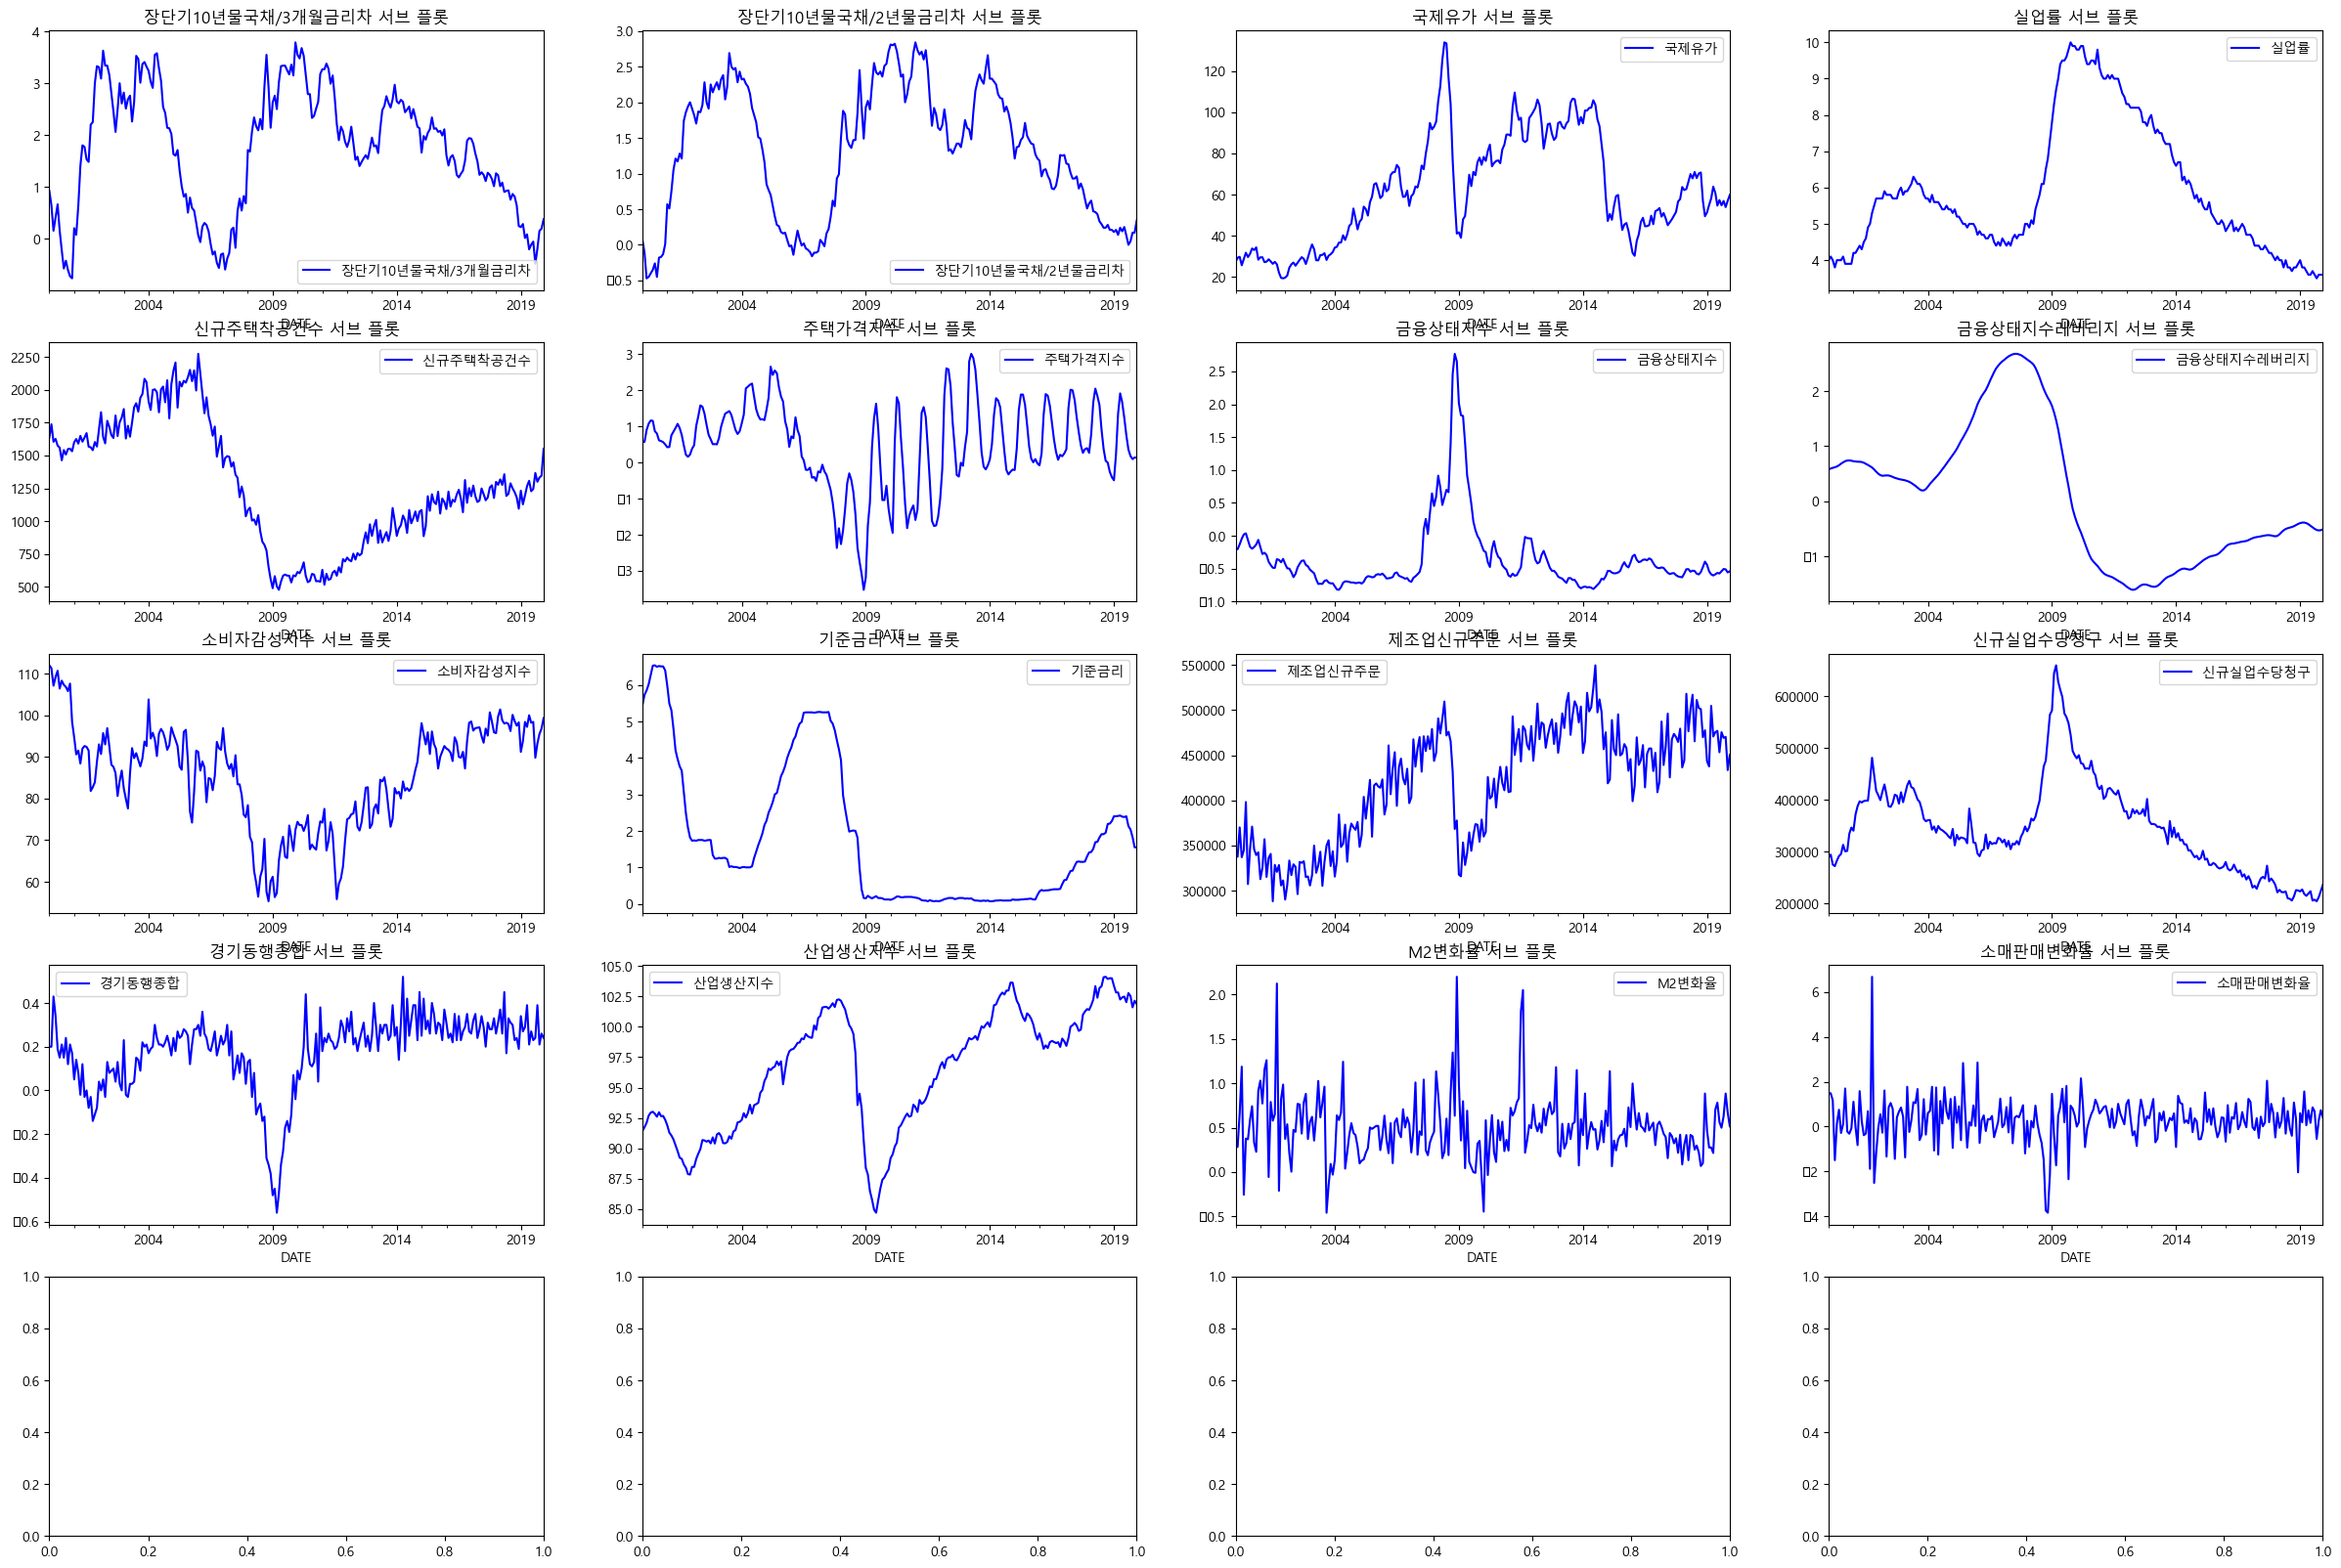

In [75]:
# 그래프 크기 조정
plt.rcParams['font.family'] ='Malgun Gothic'
가로, 세로 = 30, 20  # 원하는 크기로 조절
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(가로, 세로))  # 3행 4열의 서브 플롯 생성
# 각 컬럼에 대한 서브 플롯 그리기
for i, col in enumerate(economics.columns):
    economics.plot(y= col, kind='line', ax=axs[i//4, i%4], color='blue')
    axs[i//4, i%4].set_title(f'{col} 서브 플롯')

# 그래프 출력
plt.show()


#### 스케일링

1. min-max : 0~1까지인데 이건 시간적으로 상승하는데이터는
좋지 않아보임

2. StandardScaler

In [76]:
# # scikit-learn 패키지의 StandardScaler 클래스를 불러옵니다.
# from sklearn.preprocessing import StandardScaler
# # StandardScaler 객체를 생성합니다.
# standard_scaler = StandardScaler()
# # fit_transform()을 사용해서 학습과 스케일링을 한 번에 적용합니다.
# scaled_eocs = standard_scaler.fit_transform(economics)
# # 표준화가 완료된 데이터를 데이터프레임 형태로 변환합니다.
# scaled_eocs = pd.DataFrame(scaled_eocs,
#                               index=economics.index,
#                               columns=economics.columns)
# # 표준화가 잘 되었는지 데이터를 확인해봅시다.
# scaled_eocs.head()

In [77]:
# 민멕스 스케일링
from sklearn.preprocessing import MinMaxScaler

# MinMaxScaler 선언 및 Fitting
mMscaler = MinMaxScaler()
mMscaler.fit(economics)

# 데이터 변환
mMscaled_data = mMscaler.transform(economics)

# 데이터 프레임으로 저장
mMscaled_data = pd.DataFrame(data = mMscaled_data, index = economics.index , columns = economics.columns)

In [78]:
mMscaled_data

,장단기10년물국채/3개월금리차,장단기10년물국채/2년물금리차,국제유가,실업률,신규주택착공건수,주택가격지수,금융상태지수,금융상태지수레버리지,소비자감성지수,기준금리,제조업신규주문,신규실업수당청구,경기동행종합,산업생산지수,M2변화율,소매판매변화율
DATE,,,,,,,,,,,,,,,,
2000-01-31,0.37,0.16,0.07,0.08,0.65,0.63,0.18,0.51,1.00,0.83,0.19,0.19,0.70,0.35,0.28,0.51
2000-02-29,0.31,0.11,0.09,0.09,0.70,0.63,0.17,0.51,0.99,0.87,0.19,0.20,0.70,0.36,0.28,0.51
2000-03-31,0.20,0.00,0.09,0.08,0.63,0.68,0.19,0.52,0.91,0.89,0.31,0.16,0.92,0.38,0.42,0.48
2000-04-30,0.26,0.01,0.06,0.05,0.64,0.70,0.22,0.52,0.95,0.92,0.19,0.15,0.83,0.41,0.62,0.22
2000-05-31,0.31,0.02,0.08,0.08,0.61,0.72,0.23,0.52,0.98,0.96,0.22,0.17,0.69,0.42,0.08,0.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-31,0.06,0.14,0.31,0.02,0.50,0.59,0.08,0.26,0.61,0.32,0.72,0.01,0.74,0.93,0.36,0.43
2019-09-30,0.12,0.16,0.33,0.00,0.46,0.57,0.09,0.25,0.67,0.30,0.69,0.00,0.88,0.92,0.41,0.31
2019-10-31,0.20,0.19,0.30,0.02,0.48,0.55,0.09,0.25,0.71,0.27,0.70,0.02,0.71,0.87,0.51,0.39


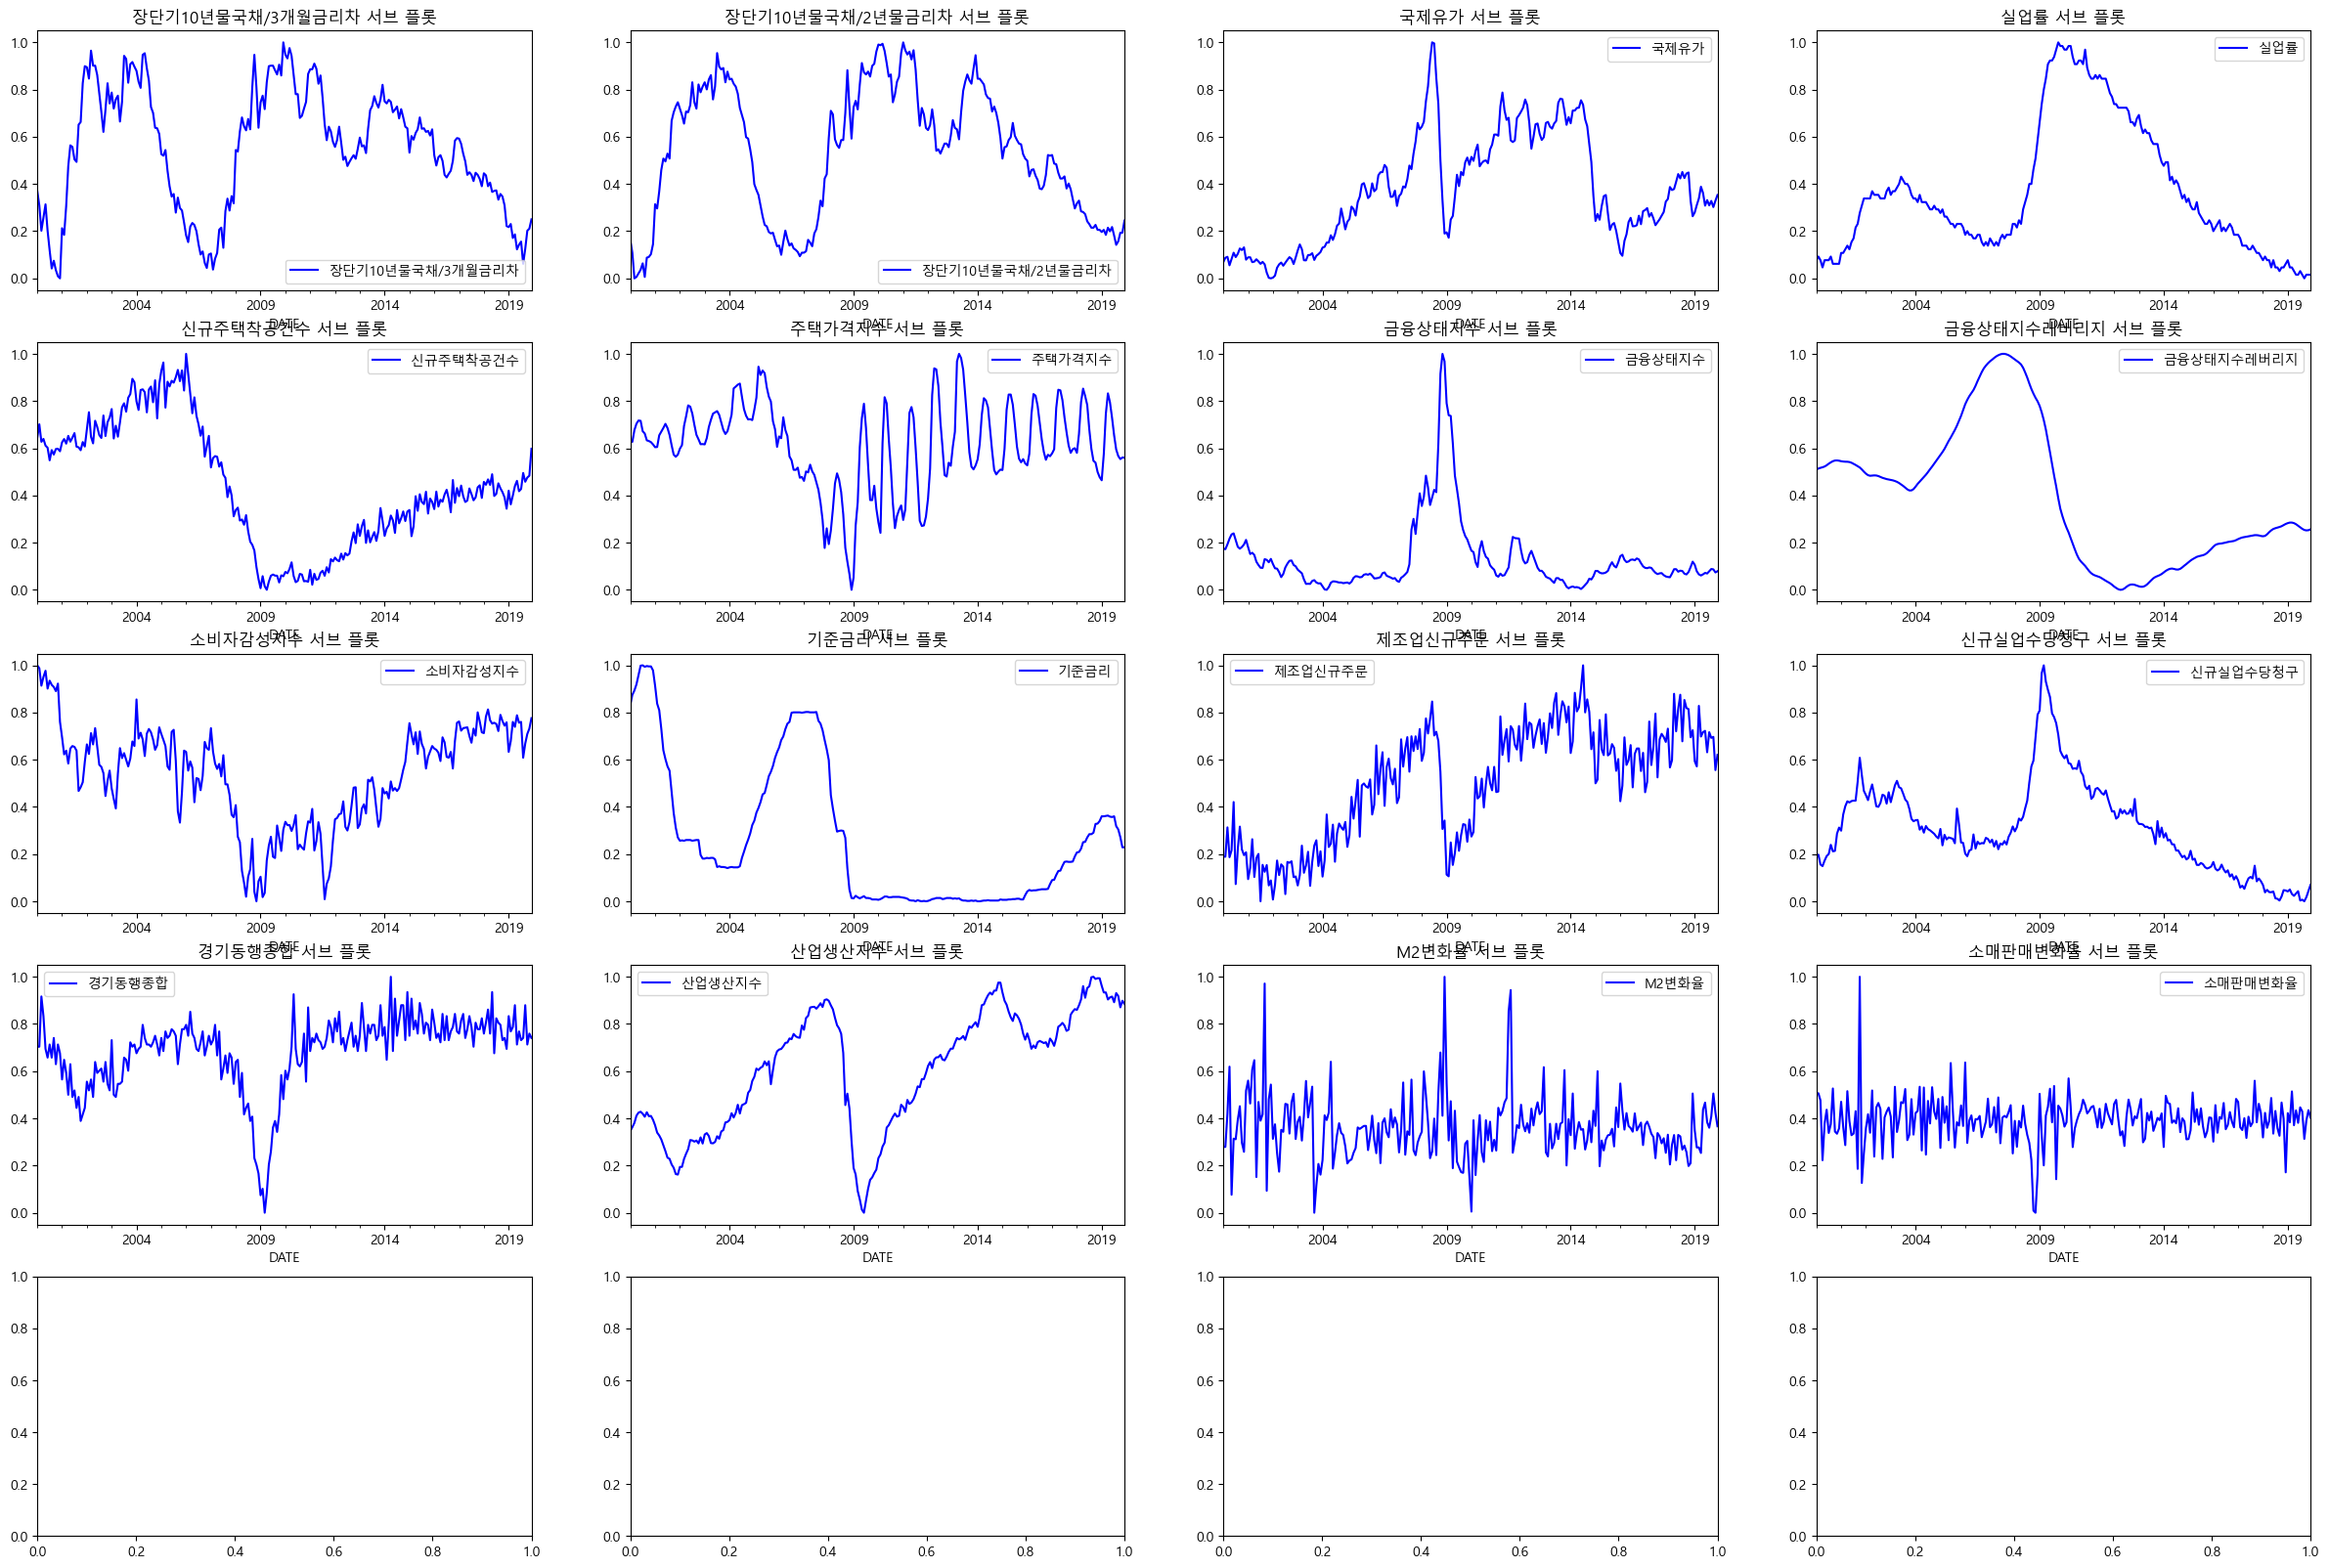

In [79]:
# 민멕스 스케일링한 데이터를 간단하게 시각화 해서 보기
가로, 세로 = 30, 20  # 원하는 크기로 조절
fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(가로, 세로))  # 3행 4열의 서브 플롯 생성
# 각 컬럼에 대한 서브 플롯 그리기
for i, col in enumerate(mMscaled_data.columns):
    mMscaled_data.plot(y= col, kind='line', ax=axs[i//4, i%4], color='blue')
    axs[i//4, i%4].set_title(f'{col} 서브 플롯')

# 그래프 출력
plt.show()

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D



#### KMeans

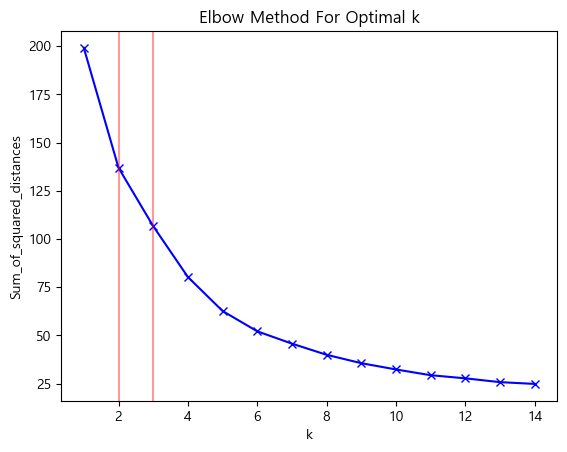

In [81]:
from sklearn.cluster import KMeans
sum_of_squared_distances = []
K = range(1, 15)
for k in K:
    km = KMeans(n_clusters = k)
    km = km.fit(mMscaled_data) # 데이터프레임 입력
    sum_of_squared_distances.append(km.inertia_)

# 시각화

plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.axvline(2,c= 'r',alpha =0.4)
plt.axvline(3,c= 'r',alpha =0.4)
plt.show()

In [82]:
from sklearn.metrics import silhouette_score
k_range = range(2,14)

best_n = -1
best_silhouette_score = -1

for k in k_range:

  kmeans = KMeans(n_clusters=k, random_state=200)
  kmeans.fit(mMscaled_data)#데이터프레임
  clusters = kmeans.predict(mMscaled_data)#데이터프레임입력

  score = silhouette_score(mMscaled_data, clusters)
  print('k :',  k, 'score :', score)

  if score > best_silhouette_score:
    best_n = k
    best_silhouette_score = score

print('best n :', best_n, 'best score :', best_silhouette_score )

k : 2 score : 0.31685352864735994
k : 3 score : 0.31564143461341204
k : 4 score : 0.35981349997547163
k : 5 score : 0.4022348822013148
k : 6 score : 0.4097729411534416
k : 7 score : 0.40621208289941074
k : 8 score : 0.41426852994646945
k : 9 score : 0.3887874329660599
k : 10 score : 0.38836680676614166
k : 11 score : 0.38075697933246805
k : 12 score : 0.3435853143177064
k : 13 score : 0.3672169283037467
best n : 8 best score : 0.41426852994646945


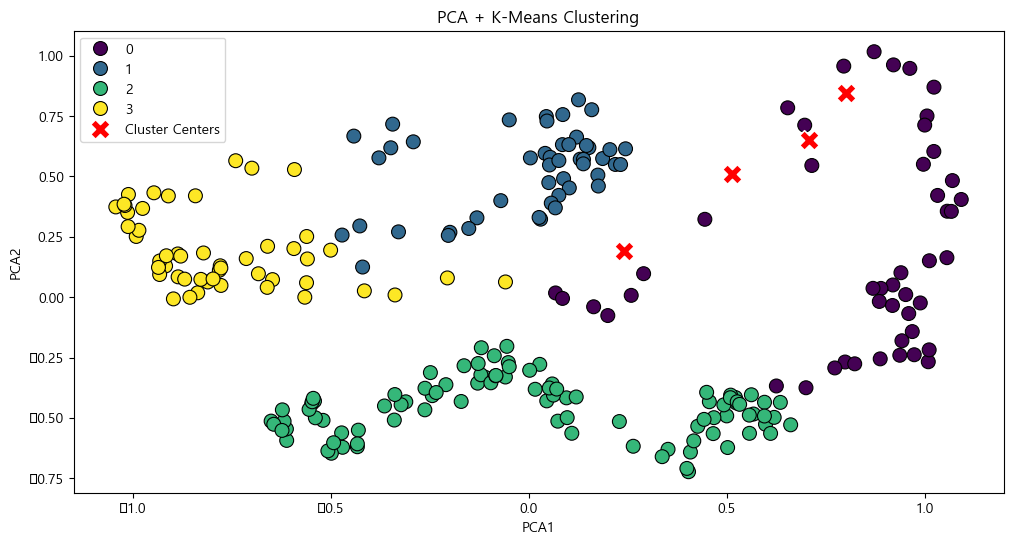

In [83]:
# KMeans 군집화
# k = 4를 기준으로 시행하였습니다.

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import pandas as pd
import numpy as np

# PCA를 사용하여 데이터 차원 축소
pca = PCA(n_components=3)
pca_result = pca.fit_transform(mMscaled_data)

# KMeans
kmeans = KMeans(n_clusters=4, init="k-means++", max_iter=300, random_state=200)
kmeans.fit(pca_result)

# 데이터 프레임에 cluster 추가
result_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2','PCA3'])
result_df['cluster'] = kmeans.labels_

# 시각화
plt.figure(figsize=(12, 6))

# 데이터 포인트 시각화 (PCA 차원 축소)
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=result_df, palette='viridis', edgecolor='k', s=100)
plt.title('PCA + K-Means Clustering')

# 군집 중심 시각화
cluster_centers = pca.inverse_transform(kmeans.cluster_centers_)  # 역변환
sns.scatterplot(x=cluster_centers[:, 0], y=cluster_centers[:, 1], marker='X', s=200, color='red', label='Cluster Centers')
plt.legend()


plt.show()

# # 개별 데이터 실루엣 계수
# score_samples = silhouette_samples(pca_result, kmeans.labels_)
# print(f'silhouette_samples( ) return 값의 shape: {score_samples.shape}')

# # 데이터 프레임에 실루엣 계수 추가
# result_df['silhouette_coeff'] = score_samples

# # 모든 데이터의 평균 실루엣 계수
# average_score = silhouette_score(pca_result, kmeans.labels_)
# print(f'Silhouette Analysis Score: {average_score:.3f}')

# # 결과 확인
# print(result_df.head())


In [84]:
# 실루엣 지수 계산
silhouette_avg = silhouette_score(pca_result, kmeans.labels_)
print(f'Silhouette Score (PCA): {silhouette_avg:.3f}')

Silhouette Score (PCA): 0.462


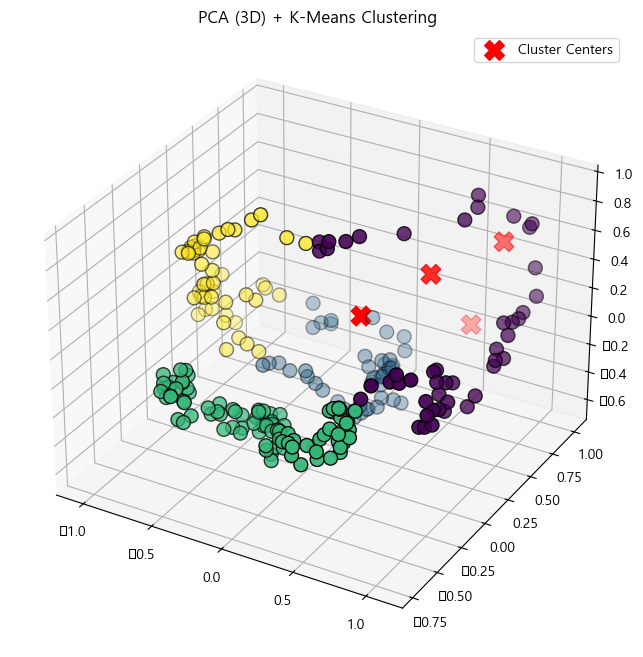

In [85]:
# PCA를 사용하여 데이터 차원 축소 (3차원)
pca = PCA(n_components=3)
pca_result_3d = pca.fit_transform(mMscaled_data)

# KMeans
kmeans_3d = KMeans(n_clusters=4, init="k-means++", max_iter=300, random_state=200)
kmeans_3d.fit(pca_result_3d)

# 데이터 프레임에 cluster 추가
result_df_3d = pd.DataFrame(pca_result_3d, columns=['PCA1', 'PCA2', 'PCA3'])
result_df_3d['cluster'] = kmeans_3d.labels_

# 시각화
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# 데이터 포인트 시각화 (3D)
scatter = ax.scatter(result_df_3d['PCA1'], result_df_3d['PCA2'], result_df_3d['PCA3'],
                     c=result_df_3d['cluster'], cmap='viridis', edgecolor='k', s=100)

# 군집 중심 시각화 (3D)
cluster_centers_3d = pca.inverse_transform(kmeans_3d.cluster_centers_)  # 역변환
ax.scatter(cluster_centers_3d[:, 0], cluster_centers_3d[:, 1], cluster_centers_3d[:, 2],
           marker='X', s=200, color='red', label='Cluster Centers')
ax.legend()

plt.title('PCA (3D) + K-Means Clustering')
plt.show()

In [86]:
# 실루엣 지수 계산
silhouette_avg_3d = silhouette_score(pca_result_3d, kmeans_3d.labels_)
print(f'Silhouette Score (PCA 3D): {silhouette_avg_3d:.3f}')

Silhouette Score (PCA 3D): 0.462


In [ ]:
result_df_3d

In [ ]:
# PCA를 수행하면 각 데이터가 어느 군집에 속하는지 알 수 없음
# 차원 축소된 데이터에 대한 군집은 알 수 있지만, 해당 군집을 기존 원래의 피쳐로 매핑하는 것은 할 수 없음

In [ ]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):

    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [ ]:
# 군집 개수 최적화
visualize_silhouette([ 2, 3, 4, 5 , 6], mMscaled_data)

In [ ]:
# 각 군집마다 해당되는 월의 개수를 표시해줍니다.
data_list = list(mMscaled_data['cluster'].value_counts())
for i, j  in enumerate(data_list) :
    print(f'{i}번째 클러스터 개수는 {j}개 입니다')